In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

FEATURE_COLS = [
    'pitch_count', 'num_pitch_types', 'max_inning',
    'rest_days', 'rolling_K_avg_3', 'rolling_K_avg_5',
    'rolling_pitch_count_5', 'rolling_K_rate',
    'opponent_k_pct', 'park_factor_K'
]
TARGET_COL = 'strikeouts'
TRAIN_SEASONS = [2021, 2022, 2023, 2024]
TEST_SEASON = 2025

In [2]:
train_dfs = [
    pd.read_parquet(f"../data/processed/pitcher_game_data_{yr}.parquet")
    for yr in TRAIN_SEASONS
]
train_df = pd.concat(train_dfs, ignore_index=True)
print(f"▶️ Training on seasons {TRAIN_SEASONS}: {train_df.shape[0]} rows")

test_df = pd.read_parquet(f"../data/processed/pitcher_game_data_{TEST_SEASON}.parquet")
print(f"▶️ Testing on season {TEST_SEASON}: {test_df.shape[0]} rows")


print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
test_df.head(100)

▶️ Training on seasons [2021, 2022, 2023, 2024]: 32438 rows
▶️ Testing on season 2025: 1461 rows
Train shape: (32438, 22)
Test shape: (1461, 22)


,game_date,pitch_count,strikeouts,max_inning,num_pitch_types,home_team,away_team,rest_days,pitcher_team,opponent_team,...,whiff_rate_expanding,csw_pct_expanding,opponent_k_pct,park_factor_K,rolling_K_avg_3,rolling_K_avg_5,rolling_pitch_count_5,rolling_K_rate,pitcher_name,pitcher_id
0,2025-04-02,93,8,6,5,SEA,DET,6,DET,SEA,...,0.0,0.0,0.218750,1.068020,5.000000,5.0,85.0,0.055000,Tarik Skubal,669373
1,2025-04-08,87,6,6,5,DET,NYY,6,DET,NYY,...,0.0,0.0,0.267857,1.087519,5.000000,5.0,85.0,0.055000,Tarik Skubal,669373
2,2025-04-14,91,9,7,5,MIL,DET,6,DET,MIL,...,0.0,0.0,0.211581,1.062781,5.000000,5.0,85.0,0.055000,Tarik Skubal,669373
3,2025-04-20,91,4,5,5,DET,KC,6,DET,KC,...,0.0,0.0,0.220820,1.087519,7.666667,5.0,85.0,0.055000,Tarik Skubal,669373
4,2025-04-27,91,11,6,5,DET,BAL,7,DET,BAL,...,0.0,0.0,0.231383,1.087519,6.333333,5.0,85.0,0.055000,Tarik Skubal,669373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-04-13,105,7,6,5,MIA,WSH,6,WSH,MIA,...,0.0,0.0,0.245614,1.009323,5.000000,5.0,85.0,0.055000,MacKenzie Gore,669022
96,2025-04-19,104,13,6,5,COL,WSH,6,WSH,COL,...,0.0,0.0,0.292969,1.020503,6.333333,5.0,85.0,0.055000,MacKenzie Gore,669022
97,2025-04-24,99,8,6,5,WSH,BAL,5,WSH,BAL,...,0.0,0.0,0.227414,0.903637,9.000000,5.0,85.0,0.055000,MacKenzie Gore,669022
98,2025-04-29,96,6,6,5,PHI,WSH,5,WSH,PHI,...,0.0,0.0,0.212418,1.030222,9.333333,8.0,100.6,0.055666,MacKenzie Gore,669022


In [3]:
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

print("Nulls in X_train:\n", X_train.isna().sum())
print("Nulls in X_test:\n", X_test.isna().sum())

Nulls in X_train:
 pitch_count              0
num_pitch_types          0
max_inning               0
rest_days                0
rolling_K_avg_3          0
rolling_K_avg_5          0
rolling_pitch_count_5    0
rolling_K_rate           0
opponent_k_pct           0
park_factor_K            0
dtype: int64
Nulls in X_test:
 pitch_count              0
num_pitch_types          0
max_inning               0
rest_days                0
rolling_K_avg_3          0
rolling_K_avg_5          0
rolling_pitch_count_5    0
rolling_K_rate           0
opponent_k_pct           0
park_factor_K            0
dtype: int64


📊Compare Multiple Models

,MAE,RMSE
LinearRegression,1.593854,4.076232
Ridge,1.589016,4.058589
XG Boost,1.574659,4.098997


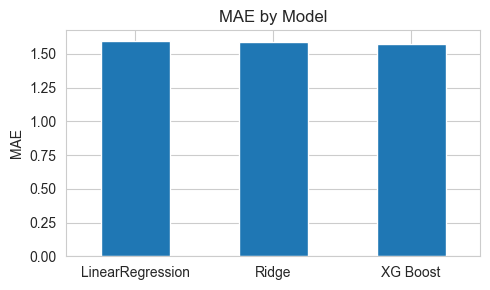

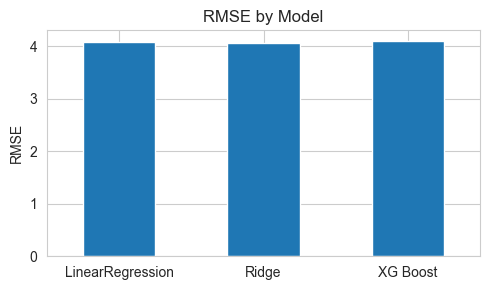

In [4]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "XG Boost": XGBRegressor(objective="reg:squarederror", n_estimators=100, verbosity=0)
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    p = mdl.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, p),
        "RMSE": mean_squared_error(y_test, p)
    }

# Display results
res_df = pd.DataFrame(results).T
display(res_df)

for metric in ["MAE", "RMSE"]:
    plt.figure(figsize=(5, 3))
    res_df[metric].plot(kind="bar")
    plt.title(f"{metric} by Model")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

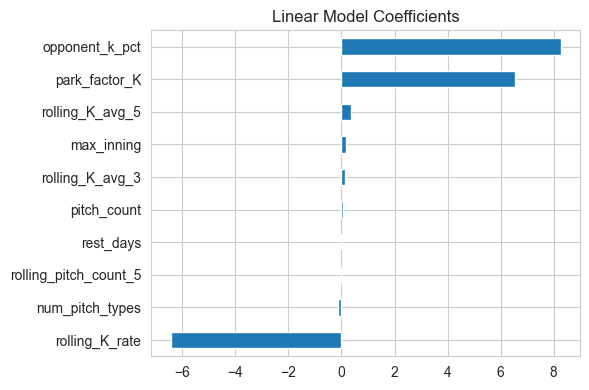

In [5]:
model = models["LinearRegression"]
coefs = pd.Series(model.coef_, index=FEATURE_COLS).sort_values()
coefs.plot(kind='barh', figsize=(6, 4))
plt.title("Linear Model Coefficients")
plt.tight_layout()
plt.show()

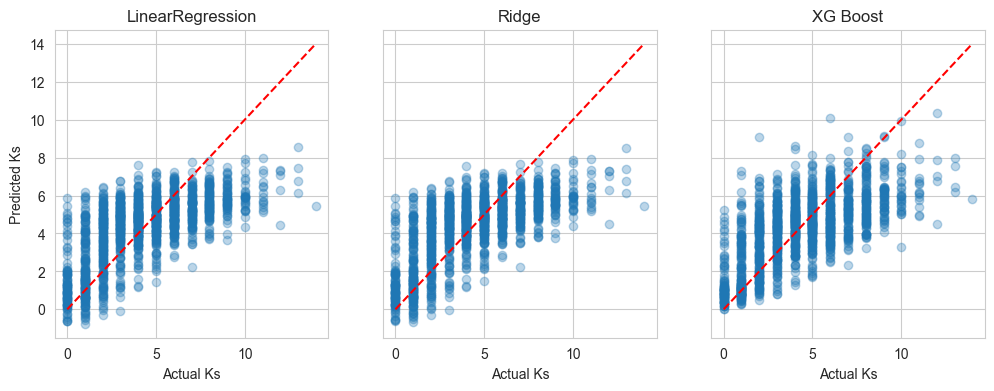

In [6]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
for ax, (name, mdl) in zip(axes, models.items()):
    p = mdl.predict(X_test)
    ax.scatter(y_test, p, alpha=0.3)
    ax.plot([0, max(y_test.max(), p.max())], [0, max(y_test.max(), p.max())], 'r--')
    ax.set_title(name)
    ax.set_xlabel("Actual Ks")
axes[0].set_ylabel("Predicted Ks")
plt.tight_layout
plt.show()

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

tscv = TimeSeriesSplit(n_splits=3)
baseline = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
    "XGB_Default": XGBRegressor(objective="reg:squarederror", n_estimators=100, verbosity=0)
}

cv_metrics = {}
for name, mdl in baseline.items():
    scores = cross_val_score(mdl, X_train, y_train,
                             cv=tscv, scoring="neg_mean_absolute_error")
    cv_metrics[name] = {
        "CV_MAE": -scores.mean(),
        "CV_Std": scores.std()
    }
cv_df = pd.DataFrame(cv_metrics).T

In [8]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.2],
}
xgb_pois = XGBRegressor(objective='count:poisson', verbosity=0)
grid = GridSearchCV(xgb_pois, param_grid, cv=tscv,
                    scoring="neg_mean_absolute_error", n_jobs=-1)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
cv_df.loc["XGB_Tuned"] = {
    "CV_MAE": -grid.best_score_,
    "CV_Std": grid.cv_results_['std_test_score'][grid.best_index_]
}
print("🏆 XGB Best Params:", grid.best_params_)

🏆 XGB Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [9]:
eval_metrics = {}
for name, mdl in {**baseline, "XGB_Tuned": best_xgb}.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    eval_metrics[name] = {
        "Test_MAE": mean_absolute_error(y_test, preds),
        "Test_RMSE": mean_squared_error(y_test, preds)
    }
eval_metrics = pd.DataFrame(eval_metrics).T

results = cv_df.join(eval_metrics)
display(results)

,CV_MAE,CV_Std,Test_MAE,Test_RMSE
Linear,1.295863,0.008010,1.593854,4.076232
Ridge,1.296425,0.007555,1.589016,4.058589
RandomForest,1.272725,0.007310,1.559028,4.021194
XGB_Default,1.313818,0.015413,1.574659,4.098997
XGB_Tuned,1.255441,0.010512,1.525147,3.837699


In [10]:
import os

metrics_dir = "../data/metrics"
metrics_path = os.path.join(metrics_dir, "whiff_added_metrics.csv")
results.to_csv(metrics_path, index=True)

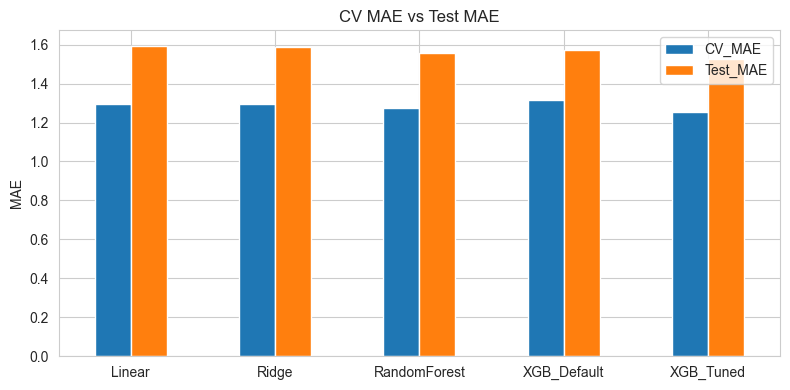

In [11]:
results[["CV_MAE", "Test_MAE"]].plot(
    kind="bar", figsize=(8,4), title="CV MAE vs Test MAE"
)
plt.ylabel("MAE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

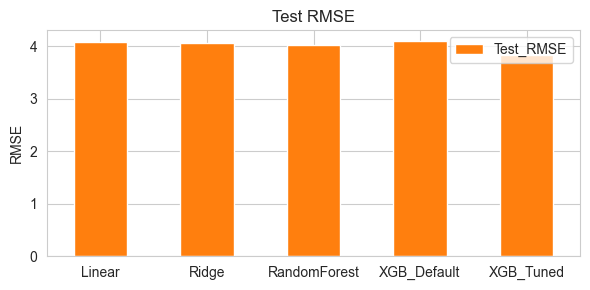

In [12]:
results[["Test_RMSE"]].plot(
    kind="bar", figsize=(6,3), color="C1", title="Test RMSE"
)
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

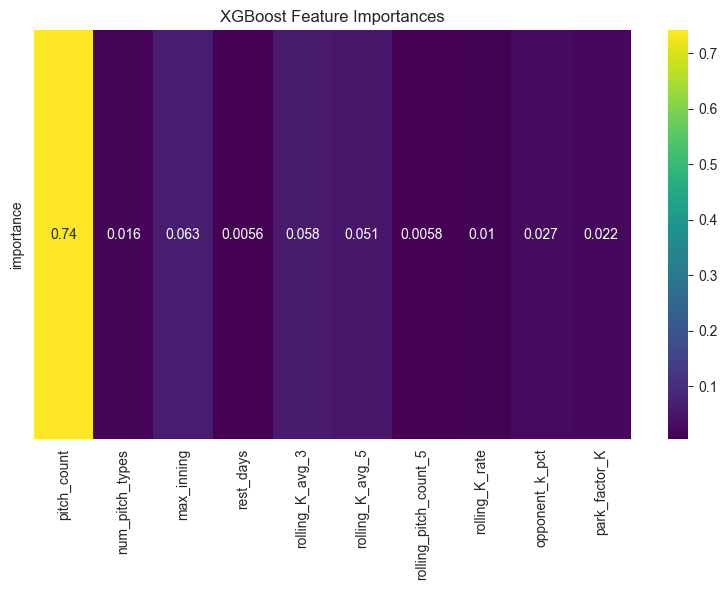

In [13]:
import seaborn as sns

importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
plt.figure(figsize=(8, 6))
sns.heatmap(importances.to_frame(name='importance').T, annot=True, cmap='viridis')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [14]:
final_model = Ridge()
final_model.fit(X_train, y_train)

Ridge()

In [15]:
from joblib import dump
dump(final_model, "../models/ridge_pitcher_k_model.joblib")

['../models/ridge_pitcher_k_model.joblib']

In [16]:
import json

meta = {
    "trained_on": "2021-2024",
    "cv_mae": round(cv_df.loc['Ridge', 'CV_MAE'], 3),
    "features": X_train.columns.tolist(),
    "notes": "Trained with TimeSeriesSplit (n=3), default alpha"
}

with open("../models/ridge_pitcher_k_model.json", "w") as f:
    json.dump(meta, f, indent=2)

In [17]:
dump(best_xgb, "../models/xgb_tuned_pitcher_k_model.joblib")
meta = {
    "trained_on": "2021-2024",
    "cv_mae": round(cv_df.loc['XGB_Tuned', 'CV_MAE'], 3),
    "features:": X_train.columns.tolist(),
    "notes": f"Trained with TimeSeriesSplit (n=3), default alpha, XGB Best Params: {grid.best_params_}"
}

with open("../models/XGB_Tuned.json", "w") as f:
    json.dump(meta, f, indent=2)